# Analisis de los proveedores

['/Users/juli/uoc/02_intensivoUOC/git/AvoEconomics', '/opt/anaconda3/lib/python39.zip', '/opt/anaconda3/lib/python3.9', '/opt/anaconda3/lib/python3.9/lib-dynload', '', '/opt/anaconda3/lib/python3.9/site-packages', '/opt/anaconda3/lib/python3.9/site-packages/aeosa', '/opt/anaconda3/lib/python3.9/site-packages/setuptools/_vendor']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 

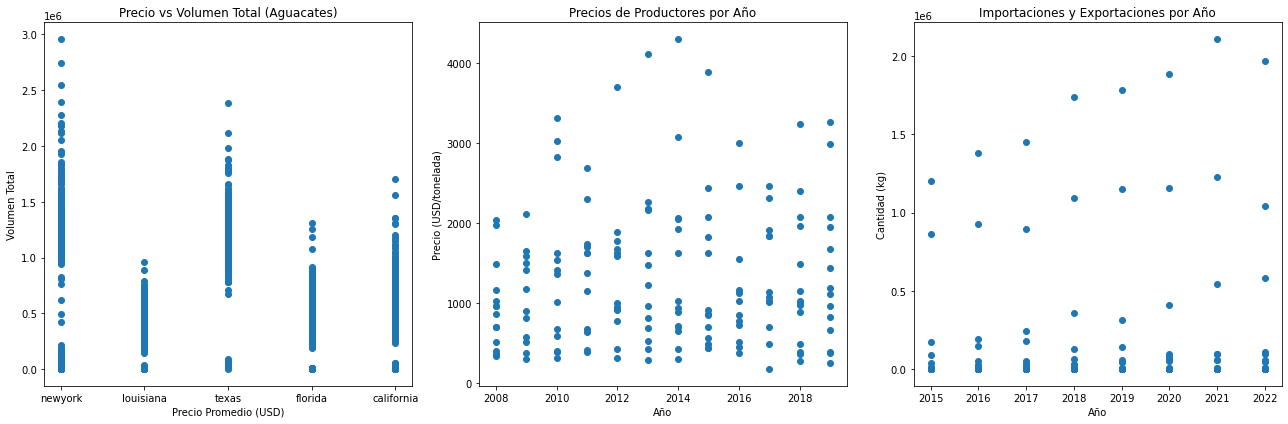

KeyError: 'Month'

KeyError: 'Month'

In [49]:
%run './EDA.ipynb'
%run './analisis-calidad-datos-y-outliers.ipynb'
%run './cohortes-avanzados.ipynb'

## **Proveedores y Seguridad de Consumo:**
**Modelo de Clasificación:** Utilizamos este modelo para el análisis de proveedores top 10.

- Ranking de Proveedores: Crear un ranking de regiones/productores según precios promedio y estabilidad de oferta a lo largo del año.
- Análisis de Vacíos de Oferta: Identificar periodos de baja oferta de ciertos productores y buscar productores alternativos con precios competitivos en esas fechas.

### Distribución por región y precio medio

In [ ]:
# Revisar la distribución de `cant_toneladas` por ubicación y tipo
distribution_summary = df_avocado_hotels.groupby(['location', 'type'])['cant_toneladas'].describe()

# Mostrar resumen de la distribución
distribution_summary.round(2)

count     mean     std     min      25%      50%  \
location   type                                                             
california conventional  507.0   578.41  200.85  238.70   437.26   526.77   
           organic       507.0    14.86    8.10    3.56     8.40    13.20   
florida    conventional  338.0   457.95  187.31  191.08   319.66   422.64   
           organic       338.0     4.58    2.43    0.08     2.71     4.30   
louisiana  conventional  338.0   389.73  153.63  148.54   259.52   363.07   
           organic       338.0     7.61    5.96    0.52     3.23     5.50   
newyork    conventional  338.0   732.08  685.92   40.51    93.11   417.51   
           organic       338.0    27.69   47.58    0.77     1.88     8.00   
texas      conventional  338.0  1195.60  226.28  676.03  1040.57  1163.63   
           organic       338.0    22.11   11.83    6.57    12.23    20.34   

                             75%      max  
location   type                            
california conventional   677.20  1706.25  
           organic         19.91    57.80  
florida    conventional   540.83  1310.67  
           organic          6.10    15.21  
louisiana  conventional   500.00   957.79  
           organic         10.94    33.97  
newyork    conventional  1283.78  2959.54  
           organic         35.82   495.08  
texas      conventional  1332.94  2381.74  
           organic         28.11    90.50

In [ ]:
# Revisar la distribución de `AveragePrice` por ubicación y tipo
distribution_summary_price = df_avocado_hotels.groupby(['location', 'type'])['AveragePrice'].describe()

# Mostrar resumen de la distribución
distribution_summary_price.round(2)

count  mean   std   min   25%   50%   75%   max
location   type                                                         
california conventional  507.0  1.24  0.29  0.61  1.04  1.21  1.43  2.20
           organic       507.0  1.97  0.44  1.05  1.63  1.96  2.30  3.25
florida    conventional  338.0  1.23  0.24  0.58  1.00  1.23  1.40  2.04
           organic       338.0  1.70  0.32  1.11  1.48  1.66  1.86  3.05
louisiana  conventional  338.0  1.08  0.19  0.58  0.96  1.04  1.16  1.72
           organic       338.0  1.57  0.30  0.62  1.39  1.55  1.70  2.75
newyork    conventional  338.0  1.38  0.23  0.77  1.19  1.36  1.54  1.99
           organic       338.0  1.91  0.24  1.32  1.79  1.92  2.06  2.65
texas      conventional  338.0  0.84  0.14  0.51  0.74  0.81  0.90  1.30
           organic       338.0  1.30  0.23  0.81  1.14  1.31  1.43  1.92

In [ ]:
# Calcular el precio medio anual que pagamos por tonelada
# Filtrar las fechas hasta diciembre de 2017
df_avocado_filtered = df_avocado_hotels[df_avocado_hotels['Date'].dt.year <= 2017]

# Calcular el precio medio anual pagado por tonelada
df_avg_price_paid = df_avocado_filtered.groupby(df_avocado_filtered['Date'].dt.year)['precio_tonelada'].mean().round().reset_index()
df_avg_price_paid.columns = ['Year', 'Avg Price Paid (USD/ton)']
df_avg_price_paid

,Year,Avg Price Paid (USD/ton)
0,2015,4960.0
1,2016,4996.0
2,2017,5654.0


### Cálculo de las exportaciones

A continuación vamos a enfocarnos en garantizar una oferta estable y evaluar la capacidad de exportación, se van a analizar volúmenes exportados y valores comerciales.

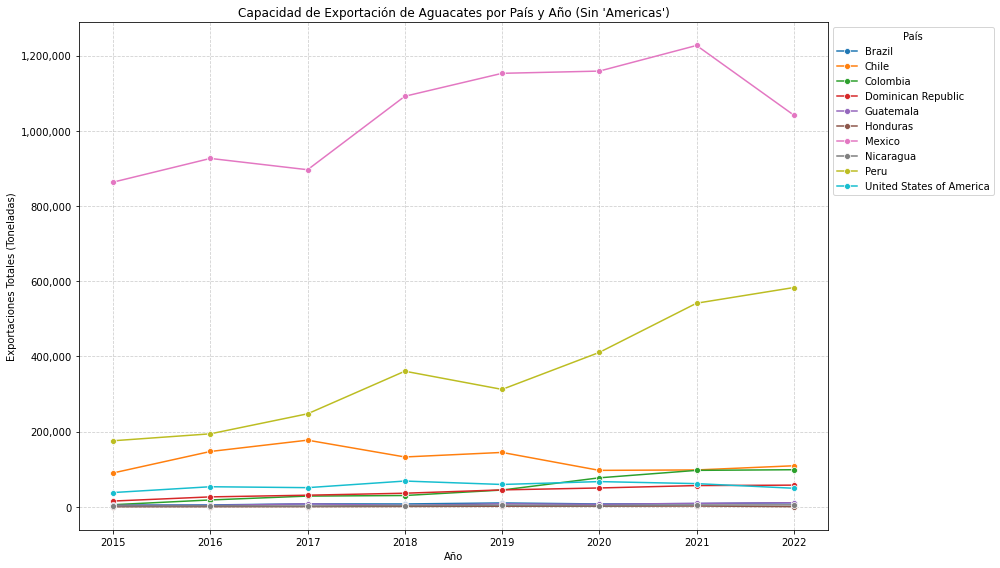

,Area,Year,Total_Export_Tons
17,Brazil,2015,4628.35
18,Brazil,2016,4950.51
19,Brazil,2017,7834.83
20,Brazil,2018,7563.70
21,Brazil,2019,10245.41
...,...,...,...
200,United States of America,2018,68476.63
201,United States of America,2019,59377.29
202,United States of America,2020,67023.89
203,United States of America,2021,61627.02


In [59]:
import matplotlib.ticker as ticker

# Calcular el total de exportaciones por país y año en toneladas
export_capacity = df_livestock[df_livestock['Element'] == 'Export Quantity'].groupby(
    ['Area', 'Year']
).agg(
    Total_Export_Tons=('Value', 'sum')
).reset_index()

# Filtrar el DataFrame para excluir "Americas"
export_capacity = export_capacity[export_capacity['Area'] != 'Americas']

# Seleccionar el Top 10 de países con mayor capacidad total de exportación
top_10_exporters = export_capacity.groupby('Area').agg(
    Total_Export_Tons=('Total_Export_Tons', 'sum')
).reset_index().sort_values(by='Total_Export_Tons', ascending=False).head(10)

# Filtrar el DataFrame original con solo los 10 principales exportadores
export_capacity_top10 = export_capacity[export_capacity['Area'].isin(top_10_exporters['Area'])]

# Crear la gráfica de líneas
plt.figure(figsize=(14, 8))
sns.lineplot(data=export_capacity_top10, x="Year", y="Total_Export_Tons", hue="Area", marker="o")

# Personalización de la gráfica
plt.title("Capacidad de Exportación de Aguacates por País y Año (Sin 'Americas')")
plt.xlabel("Año")
plt.ylabel("Exportaciones Totales (Toneladas)")

# Configurar el eje Y para mostrar los valores completos sin abreviaturas
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))  # Formato numérico con separadores de miles

plt.legend(title="País", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Mostrar la tabla actualizada
export_capacity_filtered


### Calculo de los precios de productores

In [ ]:
# Pivotar df_livestock para separar Export Quantity y Export Value
df_livestock_pivot = df_livestock.pivot_table(
    index=['Area Code (M49)', 'Area', 'Year'],
    columns='Element',
    values='Value',
    aggfunc='first'
).reset_index()

# Renombrar columnas para mayor claridad
df_livestock_pivot.columns.name = None
df_livestock_pivot.rename(columns={
    'Export Quantity': 'Export Quantity (t)',
    'Export Value': 'Export Value (1000 USD)'
}, inplace=True)

# Unir datasets usando Area Code (M49) y Year
merged_df_final_corrected = pd.merge(
    df_producer_prices, df_livestock_pivot,
    on=['Area Code (M49)', 'Year'],
    suffixes=('_producer', '_livestock'),
    how='inner'
)

,Area Code (M49),Area_producer,Element,Year,Unit,Value,Area_livestock,Export Quantity (t),Export Value (1000 USD)


In [ ]:
merged_df_final_corrected

In [ ]:
# Calcular estadísticas por región
ranking_proveedores = df_producer_prices.groupby('Area').agg(
    avg_price=('Value', 'mean'),              # Precio promedio
    price_std=('Value', 'std'),               # Desviación estándar
    min_year=('Year', 'min'),                 # Primer año registrado
    max_year=('Year', 'max'),                 # Último año registrado
    registros=('Year', 'count')               # Número de años registrados
).reset_index()

# Ordenar por precio promedio ascendente
ranking_proveedores = ranking_proveedores.sort_values(by='registros', ascending=False)

# Mostrar los 10 mejores
print(ranking_proveedores)

                                  Area    avg_price    price_std  min_year  \
2                                Chile  2182.175000   599.334643      2008   
4                   Dominican Republic   371.133333    59.879490      2008   
5                              Ecuador  1114.341667   536.731550      2008   
16                            Suriname  1633.300000   356.524672      2008   
10                              Mexico   987.766667    90.009306      2008   
12                                Peru   743.350000   179.376225      2008   
3                             Colombia  1198.363636   414.077030      2008   
6                          El Salvador   632.654545   173.012071      2008   
17            United States of America  2332.818182   547.929889      2008   
7                              Grenada  1514.400000   245.987768      2010   
0     Bolivia (Plurinational State of)   406.200000    34.364641      2008   
13                         Puerto Rico  3292.428571  1002.366639

**Precios de los proveedores por año y por región**

In [ ]:
# Crear una tabla pivote con precios por año y región
pivot_oferta = df_producer_prices.pivot_table(
    index='Year', columns='Area', values='Value'
)

# Identificar vacíos de oferta por región
missing_data = pivot_oferta.isna().sum().reset_index()
missing_data.columns = ['Area', 'Missing Years']

# Filtrar regiones con más de un año faltante
missing_data_filtered = missing_data[missing_data['Missing Years'] > 0].sort_values('Missing Years', ascending=False)

# Mostrar datos
print("Periodos de baja oferta por región:")
print(missing_data_filtered)

Periodos de baja oferta por región:
                                  Area  Missing Years
9                             Honduras             11
1                               Brazil             10
8                               Guyana              9
11                            Paraguay              8
14                         Saint Lucia              8
13                         Puerto Rico              5
15    Saint Vincent and the Grenadines              5
18  Venezuela (Bolivarian Republic of)              5
0     Bolivia (Plurinational State of)              4
7                              Grenada              2
3                             Colombia              1
6                          El Salvador              1
17            United States of America              1


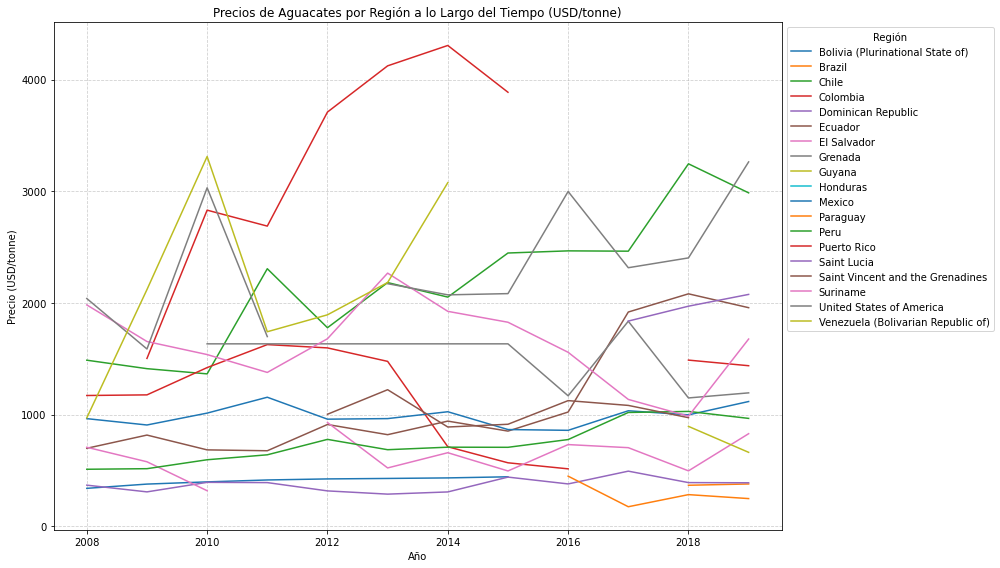

In [ ]:
import matplotlib.pyplot as plt

# Crear la tabla pivote para precios por año y región
pivot_oferta = df_producer_prices.pivot_table(
    index='Year', columns='Area', values='Value'
)

# Crear la gráfica de líneas
plt.figure(figsize=(14, 8))

# Graficar cada región con una línea diferente
for country in pivot_oferta.columns:
    plt.plot(pivot_oferta.index, pivot_oferta[country], label=country)

# Personalización del gráfico
plt.title("Precios de Aguacates por Región a lo Largo del Tiempo (USD/tonne)")
plt.xlabel("Año")
plt.ylabel("Precio (USD/tonne)")
plt.legend(title="Región", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()